In [2]:
# ! pip install botorch gpytorch


In [4]:
import numpyro
import numpy as np

In [5]:


def schwefel_1d(x):

    return 418.9829  - x * np.sin(np.sqrt(np.abs(x)))

def schwefel_nd(args):
    output = 0
    
    for dim in range(args):
        output += schwefel_1d(args[dim])

def add_gaussian_noise(signal, noise_level):

    return signal + np.random.normal(0, noise_level, 1)[0]

def schwefel_1d_with_noise(x, noise_level = 0.01):
    # Calculate the Schwefel function value

    schwefel_value = schwefel_1d(x)

    # Add Gaussian noise to the Schwefel function value

    noisy_schwefel_value = add_gaussian_noise(schwefel_value, noise_level)

    return noisy_schwefel_value

def schwefel_nd_with_noise(args, noise_level = 0.01):
    # Calculate the Schwefel function value

    schwefel_value = schwefel_nd(args)

    # Add Gaussian noise to the Schwefel function value

    noisy_schwefel_value = add_gaussian_noise(schwefel_value, noise_level)

    return noisy_schwefel_value




In [52]:

def create_data(seed, n_init, noise_level):

    np.random.seed(seed)
    X_bounds = np.array([-500,  500])
    X = np.random.uniform(X_bounds[0], X_bounds[1], size=( n_init,))
    X = np.append(X, X_bounds)
    X = np.sort(X)
    y = schwefel_1d_with_noise(X, noise_level = noise_level)

    X_unmeasured = np.linspace(X_bounds[0], X_bounds[1], 200)
    ground_truth = schwefel_1d_with_noise(X_unmeasured, noise_level = 0)
    
    return X.reshape(-1,1), y.reshape(-1,1), X_unmeasured.reshape(-1,1), ground_truth.reshape(-1,1)


In [82]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from gpytorch.distributions import MultivariateNormal
import gpytorch

def step(X_measured, y_measured, X_unmeasured):
    # Convert data to tensors
    
    
    # Initialize GP model
#     print(X_measured.shape, y_measured.unsqueeze(-1).shape)
    gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
    
    # Fit GP model
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_model(mll)
    
    # Predict on unmeasured data
    gp_model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        posterior = gp_model(torch.tensor(X_unmeasured))
        # For visualization or further processing, you can obtain mean and variance
        y_pred = posterior.mean
        y_sampled = posterior.variance.sqrt()
    
    # Compute acquisition function (Expected Improvement here)
    EI = ExpectedImprovement(model=gp_model, best_f=y_measured.max(), maximize=True)
    acq_values = EI(X_unmeasured.unsqueeze(-2))
    
    return acq_values, (y_pred, y_sampled)


In [83]:
import numpy as np

def run_gp(num_steps, X, y, X_unmeasured, ground_truth, schwefel_1d_with_noise, noise_level):
    X = torch.tensor(X)
    y = torch.tensor(y)
    X_unmeasured = torch.tensor(X_unmeasured)
    ground_truth = torch.tensor(ground_truth)
    
    for e in range(num_steps):
        print(f"\nStep {e+1}/{num_steps}")
        # Compute acquisition function and get predictions
        acq, (y_pred, y_sampled) = step(X, y, X_unmeasured)
        
        # Get the next point to evaluate
        idx = acq.argmax()  # Use argmax since EI maximizes the acquisition
        next_point = X_unmeasured[idx]
        
        # Measure the point
        next_point_value = schwefel_1d_with_noise(next_point.numpy(), noise_level)
        
        # Update measured data
        X = torch.cat([X, next_point.unsqueeze(0)], dim=0)
        y = torch.cat([y, torch.tensor([next_point_value], dtype=torch.float)], dim=0)
    
    # Calculate metrics after the loop
    mse = torch.mean((y_pred - ground_truth) ** 2).item()
    average_uncertainty = torch.mean(y_sampled).item()
    
    return mse, average_uncertainty


In [84]:
import itertools
import pandas as pd

def grid_search(seeds, n_inits, noise_levels):
    results = []  # Initialize an empty list to store results

    # Iterate over all combinations of seeds, n_inits, and noise_levels
    for seed, n_init, noise_level in itertools.product(seeds, n_inits, noise_levels):
        print(f"Seed: {seed}, n_init: {n_init}, Noise Level: {noise_level}")
        
        # Create data for the current combination
        X, y, X_unmeasured, ground_truth = create_data(seed, n_init, noise_level)
        print(X.shape)  # Should be [n, d] where d is the number of dimensions/features
        print(y.shape) 
        # Run Gaussian Process (GP) optimization/modeling for the current combination
        mse, average_uncertainty = run_gp(5, X, y, X_unmeasured, ground_truth, schwefel_1d_with_noise, noise_level)
        
        # Collect the results
        results.append({
            "Seed": seed,
            "n_init": n_init,
            "Noise_Level": noise_level,
            "MSE": mse,
            "Average_Uncertainty": average_uncertainty
        })

    # Convert the results to a pandas DataFrame for easy analysis and reporting
    results_df = pd.DataFrame(results)
    
    return results_df




In [85]:
# Define your parameter space
seeds = [1, 2, 3]
n_inits = [10, 15, 20]
noise_levels = [0, 0.01, 0.1, 0.5]

# Assuming create_data and run_gp functions are defined elsewhere

# Run the grid search
results_df = grid_search(seeds, n_inits, noise_levels)

# Display the results DataFrame
print(results_df)

Seed: 1, n_init: 10, Noise Level: 0
(12, 1)
(12, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([408.9969], dtype=torch.float64), std = tensor([192.5982], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy constru


Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 4/5

Step 5/5
Seed: 1, n_init: 10, Noise Level: 0.01
(12, 1)
(12, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([450.1581], dtype=torch.float64), std = tensor([210.8836], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy constru


Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

Seed: 1, n_init: 10, Noise Level: 0.1
(12, 1)
(12, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

Seed: 1, n_init: 10, Noise Level: 0.5
(12, 1)
(12, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

Seed: 1, n_init: 15, Noise Level: 0
(17, 1)
(17, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

Seed: 1, n_init: 15, Noise Level: 0.01
(17, 1)
(17, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

Seed: 1, n_init: 15, Noise Level: 0.1
(17, 1)
(17, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 5/5
Seed: 1, n_init: 15, Noise Level: 0.5
(17, 1)
(17, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

Seed: 1, n_init: 20, Noise Level: 0
(22, 1)
(22, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

Seed: 1, n_init: 20, Noise Level: 0.01
(22, 1)
(22, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 5/5
Seed: 1, n_init: 20, Noise Level: 0.1
(22, 1)
(22, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 5/5
Seed: 1, n_init: 20, Noise Level: 0.5
(22, 1)
(22, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

Seed: 2, n_init: 10, Noise Level: 0
(12, 1)
(12, 1)

Step 1/5

Step 2/5

Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([449.8767], dtype=torch.float64), std = tensor([150.5043], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy constru


Step 5/5
Seed: 2, n_init: 10, Noise Level: 0.01
(12, 1)
(12, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 5/5
Seed: 2, n_init: 10, Noise Level: 0.1
(12, 1)
(12, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

Seed: 2, n_init: 10, Noise Level: 0.5
(12, 1)
(12, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

Seed: 2, n_init: 15, Noise Level: 0
(17, 1)
(17, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

Seed: 2, n_init: 15, Noise Level: 0.01
(17, 1)
(17, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

Seed: 2, n_init: 15, Noise Level: 0.1
(17, 1)
(17, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

Seed: 2, n_init: 15, Noise Level: 0.5
(17, 1)
(17, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

Seed: 2, n_init: 20, Noise Level: 0
(22, 1)
(22, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 5/5
Seed: 2, n_init: 20, Noise Level: 0.01
(22, 1)
(22, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

Seed: 2, n_init: 20, Noise Level: 0.1
(22, 1)
(22, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 5/5
Seed: 2, n_init: 20, Noise Level: 0.5
(22, 1)
(22, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

Seed: 3, n_init: 10, Noise Level: 0
(12, 1)
(12, 1)

Step 1/5

Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

Seed: 3, n_init: 10, Noise Level: 0.01
(12, 1)
(12, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 5/5
Seed: 3, n_init: 10, Noise Level: 0.1
(12, 1)
(12, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 5/5
Seed: 3, n_init: 10, Noise Level: 0.5
(12, 1)
(12, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([382.9140], dtype=torch.float64), std = tensor([229.6067], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy constru


Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

Seed: 3, n_init: 15, Noise Level: 0
(17, 1)
(17, 1)

Step 1/5

Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

Seed: 3, n_init: 15, Noise Level: 0.01
(17, 1)
(17, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 3/5

Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

Seed: 3, n_init: 15, Noise Level: 0.1
(17, 1)
(17, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 4/5


/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([419.9207], dtype=torch.float64), std = tensor([200.3570], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy constru


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([411.2736], dtype=torch.float64), std = tensor([199.2637], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy constru

Seed: 3, n_init: 15, Noise Level: 0.5
(17, 1)
(17, 1)

Step 1/5

Step 2/5


/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([426.5274], dtype=torch.float64), std = tensor([211.1230], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy constru


Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

Seed: 3, n_init: 20, Noise Level: 0
(22, 1)
(22, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 5/5
Seed: 3, n_init: 20, Noise Level: 0.01
(22, 1)
(22, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([415.3410], dtype=torch.float64), std = tensor([178.7128], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy constru


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

Seed: 3, n_init: 20, Noise Level: 0.1
(22, 1)
(22, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 2/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 3/5

Step 4/5


/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([451.0280], dtype=torch.float64), std = tensor([194.0727], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy constru


Step 5/5
Seed: 3, n_init: 20, Noise Level: 0.5
(22, 1)
(22, 1)

Step 1/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 2/5

Step 3/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 


Step 4/5

Step 5/5


/tmp/ipykernel_1292286/1166517645.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = gp_model(torch.tensor(X_unmeasured))
/tmp/ipykernel_1292286/1166517645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp_model = SingleTaskGP(torch.tensor(X_measured), torch.tensor(y_measured))
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/nfs/home/upratius/.conda/envs/gpax_hae/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is 

    Seed  n_init  Noise_Level           MSE  Average_Uncertainty
0      1      10         0.00  42108.119088            17.544797
1      1      10         0.01  40813.529530            15.307410
2      1      10         0.10  37841.945077            15.802484
3      1      10         0.50  37550.871366             3.830761
4      1      15         0.00  38389.632000            14.470949
5      1      15         0.01  38349.540837            12.016277
6      1      15         0.10  37489.492780            11.868182
7      1      15         0.50  38289.508883             3.746136
8      1      20         0.00  40191.983264             3.811547
9      1      20         0.01  37858.782132            22.654309
10     1      20         0.10  37773.534062            17.449285
11     1      20         0.50  40106.162783            20.949178
12     2      10         0.00  40301.273881            19.379407
13     2      10         0.01  40308.008804            19.379004
14     2      10         

In [86]:
results_df.to_csv('grid_search_results_botorch.csv', index=False)

In [87]:
results_df

,Seed,n_init,Noise_Level,MSE,Average_Uncertainty
0,1,10,0.00,42108.119088,17.544797
1,1,10,0.01,40813.529530,15.307410
2,1,10,0.10,37841.945077,15.802484
3,1,10,0.50,37550.871366,3.830761
4,1,15,0.00,38389.632000,14.470949
5,1,15,0.01,38349.540837,12.016277
6,1,15,0.10,37489.492780,11.868182
7,1,15,0.50,38289.508883,3.746136
8,1,20,0.00,40191.983264,3.811547
9,1,20,0.01,37858.782132,22.654309


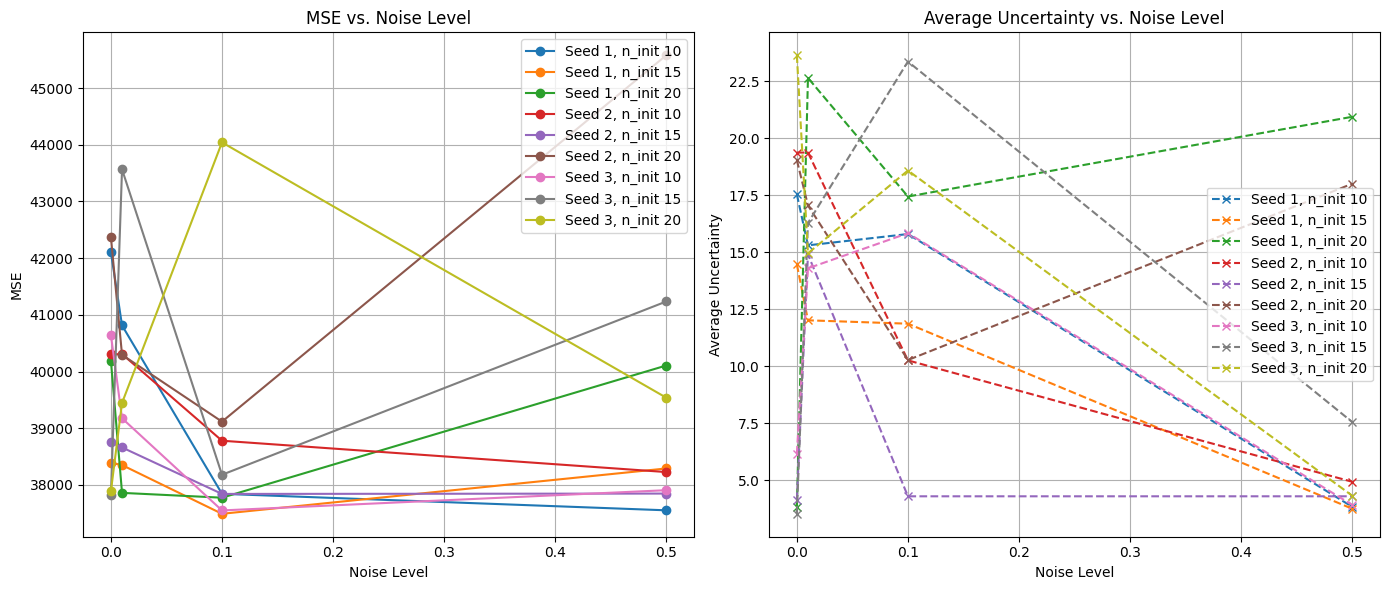

In [88]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the list of dictionaries into a DataFrame for easier manipulation
df = results_df

# Plot settings
plt.figure(figsize=(14, 6))

# Plot 1: MSE
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
for key, grp in df.groupby(['Seed', 'n_init']):
    plt.plot(grp['Noise_Level'], grp['MSE'], marker='o', linestyle='-', label=f'Seed {key[0]}, n_init {key[1]}')
plt.title('MSE vs. Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

# Plot 2: Average Uncertainty
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
for key, grp in df.groupby(['Seed', 'n_init']):
    plt.plot(grp['Noise_Level'], grp['Average_Uncertainty'], marker='x', linestyle='--', label=f'Seed {key[0]}, n_init {key[1]}')
plt.title('Average Uncertainty vs. Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Average Uncertainty')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
